In [1]:
import numpy as np
import torch

In [2]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# https://plotly.com/python/creating-and-updating-figures/
import plotly.graph_objects as go

from mpl_toolkits import mplot3d

In [4]:
import sys
sys.path.append('../') # now can access entire repository, (important when running locally)

# from orbit_datasets import neworbits, versatileorbits, staticorbits
from ldcl.data import neworbits, versatileorbits, staticorbits

In [5]:
orbits_dataset = neworbits.OrbitsDataset()
orbits_loader = torch.utils.data.DataLoader(
    dataset = orbits_dataset,
    shuffle = True,
    batch_size = 1,
)

It took 2.2490177154541016 time to finish the job.


In [6]:
def getRepresentations(encoder_location):
    branch_encoder = torch.load(encoder_location, map_location=torch.device('cpu'))
    branch_encoder.eval()
    
    encoder_outputs_list = []
    target_values = []

    for it, (input1, input2, y) in enumerate(orbits_loader):
        predicted_representation = branch_encoder(input1.float()).detach().numpy()[0]
        encoder_outputs_list.append(predicted_representation)

        #append conserved quantities to the end of the representation for plotting, y = (1, )
        #[2=phi0,3=energy,4=angular_momentum] discard [0=eccentricity, 1=semimajor_axis]
        target_values.append(np.array([y[0][2],y[0][3],y[0][4]]))
        
    encoder_outputs = np.vstack(encoder_outputs_list)
    target_values = np.vstack(target_values)

    phi0_c_values = target_values[:,0]
    energy_c_values = target_values[:,1]
    angular_momentum_c_values = target_values[:,2]
    
    return encoder_outputs, [phi0_c_values, energy_c_values, angular_momentum_c_values]

In [7]:
ENCODER_PATH = "saved_models/3Dorbits_rmseNCE/final_encoder.pt"
encoder_outputs, conserved_quantities = getRepresentations(ENCODER_PATH)

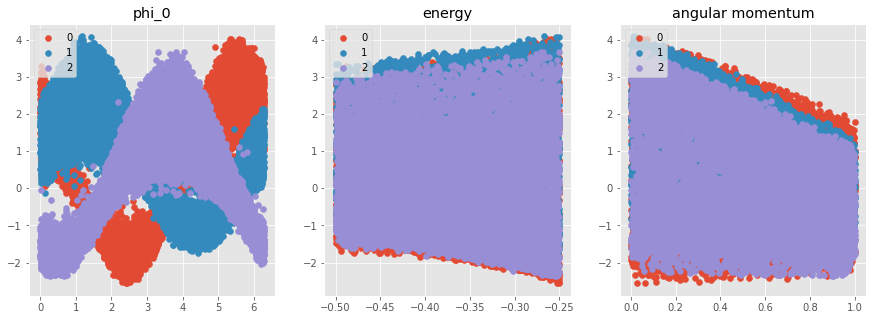

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

numshown = 10000


for i in range(3):
    ax1.scatter(conserved_quantities[0][:numshown], encoder_outputs[:numshown,i])

ax1.set_title("phi_0")
ax1.legend(['0', '1', '2'], loc = 'upper left')

for i in range(3):
    ax2.scatter(conserved_quantities[1][:numshown], encoder_outputs[:numshown,i])

ax2.set_title("energy")
ax2.legend(['0', '1', '2'], loc = 'upper left')

for i in range(3):
    ax3.scatter(conserved_quantities[2][:numshown], encoder_outputs[:numshown,i])

ax3.set_title("angular momentum")
ax3.legend(['0', '1', '2'], loc = 'upper left')

plt.show()

In [42]:
fig = go.Figure(
        data=[go.Scatter3d(
        x=encoder_outputs[:numshown, 0],
        y=encoder_outputs[:numshown, 1],
        z=encoder_outputs[:numshown, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=conserved_quantities[2][:numshown], # 0 for angle, 1 for energy, 2 for angular momentum
            colorscale='viridis',
            opacity=1,
            showscale = True
        )
    )],
    layout=go.Layout(height=800, width=1000)
)
#fig.show()

In [44]:
for i in range(3):
    simple_reg = LinearRegression().fit(encoder_outputs, conserved_quantities[i])
    print(i,simple_reg.score(encoder_outputs, conserved_quantities[i]))

0 0.5670178494547469
1 0.0037387645412528814
2 0.9804645518510208


In [45]:
for i in range(3):
    sv_reg = SVR().fit(encoder_outputs, conserved_quantities[i])
    print(i, sv_reg.score(encoder_outputs, conserved_quantities[i]))

0 0.8787628267687622
1 0.5483547241111144
2 0.9819404326165755


In [32]:
for i in range(3):
    sv_reg = SVR(kernel = 'poly').fit(encoder_outputs, conserved_quantities[i])
    print(i, sv_reg.score(encoder_outputs, conserved_quantities[i]))

0 0.5977559451200569
1 0.10550804850179585
2 0.8748155632794641


In [40]:
augmented_outputs = np.concatenate((encoder_outputs, np.square(encoder_outputs)), axis = 1)
augmented_outputs.shape

for i in range(3):
    simple_reg = LinearRegression().fit(augmented_outputs, conserved_quantities[i])
    print(i,simple_reg.score(augmented_outputs, conserved_quantities[i]))

0 0.6761390827217698
1 0.7934316211581205
2 0.9888866946027073


In [9]:
print(encoder_outputs.shape)

(10240, 3)


In [15]:
print(conserved_quantities[2].shape)
# phi_0, energy, angular momentum

(10240,)


In [16]:
print(conserved_quantities[2])

[0.66979156 0.39920058 0.66110602 ... 0.31188488 0.77495408 0.55930453]


In [46]:
p = np.random.permutation(10240)
print(p.shape)

(10240,)


In [47]:
encodings_copy = encoder_outputs[p]
phi_0_copy = conserved_quantities[0][p]
energy_copy = conserved_quantities[1][p]
angular_copy = conserved_quantities[2][p]
#print(encodings_copy.shape)
#print(angular_copy.shape)

In [48]:
neigh = NearestNeighbors(n_neighbors = 5)
neigh.fit(encodings_copy[:-100])

NearestNeighbors()

In [56]:
#nbrs = neigh.kneighbors(encodings_copy[-100:], n_neighbors = 10, return_distance = False)

In [71]:
import math
phi_0_distances = []
energy_distances = []
angular_distances = []

nbrs = neigh.kneighbors(encodings_copy[-100:], n_neighbors = 2, return_distance = False)

for i, x,y,z in zip(nbrs, phi_0_copy[-100:], energy_copy[-100:], angular_copy[-100:]):
    angle_diff = np.mean(phi_0_copy[i]) - x
    if angle_diff < 0:
        angle_diff *= -1
    if angle_diff > math.pi:
        angle_diff = 2*math.pi - angle_diff
    phi_0_distances.append(angle_diff ** 2)
    energy_distances.append((np.mean(energy_copy[i]) - y)**2)
    angular_distances.append((np.mean(angular_copy[i]) - z)**2)


print(np.mean(phi_0_distances) / (2*math.pi)**2)
print(np.mean(energy_distances) * 16)
print(np.mean(angular_distances))

0.005014954874157305
0.009762364828439599
0.0008801716493873529


In [68]:
import math
phi_0_distances = []
energy_distances = []
angular_distances = []

nbrs = neigh.kneighbors(encodings_copy[-100:], n_neighbors = 1, return_distance = False)

for i, x,y,z in zip(nbrs, phi_0_copy[-100:], energy_copy[-100:], angular_copy[-100:]):
    angle_diff = np.mean(phi_0_copy[i]) - x
    if angle_diff < 0:
        angle_diff *= -1
    if angle_diff > math.pi:
        angle_diff = 2*math.pi - angle_diff
    phi_0_distances.append(angle_diff ** 2)
    energy_distances.append((np.mean(energy_copy[i]) - y)**2)
    angular_distances.append((np.mean(angular_copy[i]) - z)**2)


print(np.mean(phi_0_distances) / (2*math.pi)**2)
print(np.mean(energy_distances) * 16)
print(np.mean(angular_distances))

8.247822990054273e-05
0.014147435698881432
0.0010187786700862579


In [59]:
print(phi_0_copy[nbrs[0]])
print(np.mean(phi_0_copy[nbrs[0]]))

[1.95470671 2.04834557 2.03508746 1.95516373 2.01555571 1.9676533
 2.00565308 1.95330953 2.03920835 1.95147866]
1.9926162083267431
